In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.stats.ts.upcross import propagate_upcross
from sigcorr.tools.stats.gp.euler_number import GPEulerNumberPropagator

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import EulerNumberCalc
from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import TestStatisticCalc
from sigcorr.mapreduce.map_reducers import OverflowsCalc
from sigcorr.mapreduce.map_reducers import MathCalc
from sigcorr.mapreduce.map_reducers import ChainCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.models.gross_vitells import GrossVitells
from sigcorr.models.gross_vitells_asimov import GrossVitellsAsimov
from sigcorr.models.hyy import Hyy
from sigcorr.models.hyy_asimov import HyyAsimov
from sigcorr.models.hyy_2d import Hyy2D
from sigcorr.models.hyy_2d_asimov import Hyy2DAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size

set_plt_reasonable_defaults(plt)

In [2]:
#input_file = "../../output/alex_exp-1m.h5"
#input_file = "../../output/gross_vitells-1m.h5"
input_file = "../../output/hyy2d_dense-100k.h5"
asimov_input_file = input_file.split("-")[0]+"-asimov.h5"

In [3]:
#true_model = GrossVitells(None)
#true_model = Hyy(None)
true_model = Hyy2D(None)
set_params_from_file(true_model, input_file)
true_model.init()

In [4]:
true_res_part = {}
with h5py.File(input_file, "r", swmr=True) as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        true_res_part[field] = f[field][:1000, ...]
    #true_res_part["sig_std"] = f.attrs["sig_std"]

In [5]:
asimov_res = {}
with h5py.File(input_file.split("-")[0] + "-asimov.h5", "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        asimov_res[field] = f[field][...]

In [6]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:54<00:00, 872.25it/s]


In [7]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 18835.86it/s]


In [8]:
LOCAL_SIG_GRID = np.arange(0, 7.05, 0.1)

In [9]:
c0 = LOCAL_SIG_GRID[7]
c1 = LOCAL_SIG_GRID[10]

In [10]:
asimov_gp_euler_number_covcalc0, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 1_000_000, 300, true_res_part["scan_xs"].shape[:-1], ChainCalc([MathCalc(np.square), EulerNumberCalc(c0**2)]), BatchStats1Reduce()))
asimov_gp_euler_number0, asimov_gp_euler_number_err0 = asimov_gp_euler_number_covcalc0.get_mean(), asimov_gp_euler_number_covcalc0.get_stat_err()

asimov_gp_euler_number_covcalc1, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 1_000_000, 300, true_res_part["scan_xs"].shape[:-1], ChainCalc([MathCalc(np.square), EulerNumberCalc(c1**2)]), BatchStats1Reduce()))
asimov_gp_euler_number1, asimov_gp_euler_number_err1 = asimov_gp_euler_number_covcalc1.get_mean(), asimov_gp_euler_number_covcalc1.get_stat_err()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000200/1000200 [02:46<00:00, 5992.41it/s]


In [11]:
gp_euler_number_covcalc0, _ = get_last_from_iter(gp_batch_mapreduce(true_cov, 1_000_000, 300, true_res_part["scan_xs"].shape[:-1], ChainCalc([MathCalc(np.square), EulerNumberCalc(c0**2)]), BatchStats1Reduce()))
gp_euler_number0, gp_euler_number_err0 = gp_euler_number_covcalc0.get_mean(), gp_euler_number_covcalc0.get_stat_err()

gp_euler_number_covcalc1, _ = get_last_from_iter(gp_batch_mapreduce(true_cov, 1_000_000, 300, true_res_part["scan_xs"].shape[:-1], ChainCalc([MathCalc(np.square), EulerNumberCalc(c1**2)]), BatchStats1Reduce()))
gp_euler_number1, gp_euler_number_err1 = gp_euler_number_covcalc1.get_mean(), gp_euler_number_covcalc1.get_stat_err()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000200/1000200 [03:05<00:00, 5378.07it/s]


In [12]:
asimov_propagator = GPEulerNumberPropagator(np.array([c0, c1]), np.array([asimov_gp_euler_number0, asimov_gp_euler_number1]).ravel())

In [13]:
gp_propagator = GPEulerNumberPropagator(np.array([c0, c1]), np.array([gp_euler_number0, gp_euler_number1]).ravel())

In [14]:
true_euler_num_scan = []
for local_sig in LOCAL_SIG_GRID:
    true_euler_num_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes"], 20000, ChainCalc([TestStatisticCalc(), EulerNumberCalc(local_sig**2)]), BatchStats1Reduce()))
    true_euler_num, true_euler_num_err = true_euler_num_covcalc.get_mean(), true_euler_num_covcalc.get_stat_err()
    true_euler_num_scan.append(true_euler_num)
true_euler_num_scan = np.array(true_euler_num_scan)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 27051.79it/s]


In [15]:
true_propagator = GPEulerNumberPropagator(LOCAL_SIG_GRID[[7, 10]], true_euler_num_scan[[7, 10]].ravel())

In [16]:
true_pval_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes"], 20000, ChainCalc([TestStatisticCalc(), MathCalc(lambda x: x.reshape(*x.shape[:1], -1)), OverflowsCalc(LOCAL_SIG_GRID**2)]), BatchStats1Reduce()))
true_pval, true_pval_err = true_pval_covcalc.get_mean(), true_pval_covcalc.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:14<00:00, 1340.59it/s]


In [17]:
gp_pval_covcalc, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 1_000_000, 500, [np.product(true_res_part["scan_xs"].shape[:-1])], ChainCalc([MathCalc(np.square), OverflowsCalc(LOCAL_SIG_GRID**2)]), BatchStats1Reduce()))
gp_pval, gp_pval_err = gp_pval_covcalc.get_mean(), gp_pval_covcalc.get_stat_err()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:16<00:00, 7300.51it/s]


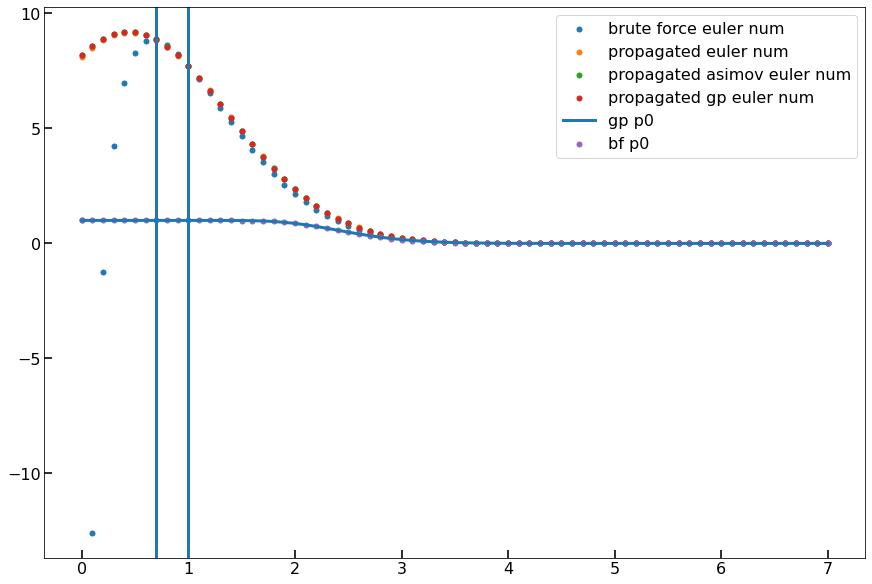

In [18]:
plt.scatter(LOCAL_SIG_GRID, true_euler_num_scan.ravel(), label="brute force euler num")
plt.scatter(LOCAL_SIG_GRID, true_propagator.calc(LOCAL_SIG_GRID), label="propagated euler num")
plt.scatter(LOCAL_SIG_GRID, asimov_propagator.calc(LOCAL_SIG_GRID), label="propagated asimov euler num")
plt.scatter(LOCAL_SIG_GRID, gp_propagator.calc(LOCAL_SIG_GRID), label="propagated gp euler num")
plt.plot(LOCAL_SIG_GRID, gp_pval, label="gp p0", ls="-")
plt.scatter(LOCAL_SIG_GRID, true_pval, label="bf p0")
plt.axvline(LOCAL_SIG_GRID[7])
plt.axvline(LOCAL_SIG_GRID[10])
#plt.scatter(LOCAL_SIG_GRID, direct_asimov_upcross_scan - propagate_upcross(c0**2, direct_true_upcross_scan[7], 1, LOCAL_SIG_GRID**2), label="direct asimov upcross")
#plt.yscale("log")
plt.legend()

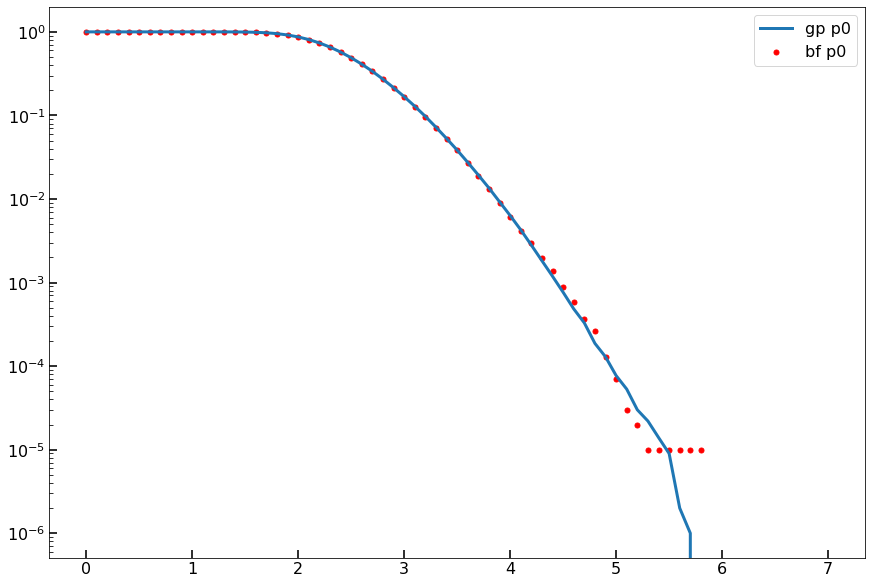

In [19]:
plt.plot(LOCAL_SIG_GRID, gp_pval, label="gp p0", ls="-")
plt.scatter(LOCAL_SIG_GRID, true_pval, label="bf p0", color="red")
plt.yscale("log")
plt.legend()